#### Library import

In [159]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from ngboost import NGBRegressor
from scipy.stats import norm, skew

from matplotlib.ticker import FormatStrFormatter

import re
from tqdm import tqdm

#### GPU setting

In [160]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [161]:
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = InteractiveSession(config = config)

In [162]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17250986802353240297
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3435973836
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6468399577408728849
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.6"
]


In [163]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

#### Data import and preprocessing

In [164]:
data = pd.read_csv("data/data.csv")
data.columns

Index(['OBJECTID_x', 'ID', 'pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope',
       'altitude', 'profile_curve', 'profile_c_num', 'profile_c_abs',
       'planform_curve', 'planform_c_num', 'planform_c_abs', 'HYDGRP',
       'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C', 'HYDGRP_D', 'ANION_EXCL', 'SOL_CRK',
       'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'SOL_EC1', 'distance'],
      dtype='object')

In [165]:
data = data.drop(['OBJECTID_x','ID','HYDGRP','profile_c_num', 'profile_c_abs','planform_c_num', 'planform_c_abs','ANION_EXCL','SOL_CRK','SOL_EC1'], axis = 1)
data.columns

Index(['pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope', 'altitude',
       'profile_curve', 'planform_curve', 'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C',
       'HYDGRP_D', 'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'distance'],
      dtype='object')

In [166]:
As = data
Cd = data
Ni = data

In [167]:
As = As.drop(["Cd", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Cd = Cd.drop(["As", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Ni = Ni.drop(["As", "Cd", "Pb", "Zn", "Hg"], axis = 1)

In [168]:
print(As.shape)
print(Cd.shape)
print(Ni.shape)

(1458, 16)
(1458, 16)
(1458, 16)


#### Oversampling by SMOGN (SMOTE Regression)

In [169]:
import smogn

In [170]:
As_smogn = smogn.smoter(data = As, y = 'As', samp_method = 'extreme')
Cd_smogn = smogn.smoter(data = Cd, y = 'Cd', samp_method = 'extreme')
Ni_smogn = smogn.smoter(data = Ni, y = 'Ni', samp_method = 'extreme')

dist_matrix:   1%|          | 2/248 [00:00<00:23, 10.59it/s]

synth_matrix: 100%|##########| 242/242 [00:01<00:00, 157.23it/s]


In [171]:
print(As_smogn.shape)
print(Cd_smogn.shape)
print(Ni_smogn.shape)

(2183, 16)
(2151, 16)
(2183, 16)


#### Eliminate outlier and train / test split

In [172]:
def eli_outlier(data, value):
    q1 = data[value].quantile(0.25)
    q3 = data[value].quantile(0.75)

    iqr = q3 - q1

    q1_condition = data[value] < q1-1.5*iqr
    q3_condition = data[value] > q3+1.5*iqr

    reset_q1_index = data[q1_condition].index
    reset_q3_index = data[q3_condition].index

    data.drop(reset_q1_index, inplace = True)
    data.drop(reset_q3_index, inplace = True)

    return data

In [173]:
As_ros = eli_outlier(As_smogn, "As")
Cd_ros = eli_outlier(Cd_smogn, "Cd")
Ni_ros = eli_outlier(Ni_smogn, "Ni")

In [174]:
As_X = As_ros.drop(["As"], axis=1)
Cd_X = Cd_ros.drop(["Cd"], axis=1)
Ni_X = Ni_ros.drop(["Ni"], axis=1)

As_y = As_ros["As"]
Cd_y = Cd_ros["Cd"]
Ni_y = Ni_ros["Ni"]

In [175]:
As_y = np.log1p(As_ros["As"])
Cd_y = np.log1p(Cd_ros["Cd"])
Ni_y = np.log1p(Ni_ros["Ni"])

In [176]:
print(As_X.shape)
print(Cd_X.shape)
print(Ni_X.shape)

(1657, 15)
(1733, 15)
(2073, 15)


StandardScaler

In [177]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
As_X_scaled = scaler.fit_transform(As_X)
Cd_X_scaled = scaler.fit_transform(Cd_X)
Ni_X_scaled = scaler.fit_transform(Ni_X)

As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.3, random_state=42)
Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.3, random_state=42)
Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.3, random_state=42)

MinMaxScaler

In [178]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# As_X_scaled = scaler.fit_transform(As_X)
# Cd_X_scaled = scaler.fit_transform(Cd_X)
# Ni_X_scaled = scaler.fit_transform(Ni_X)

# As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)
# Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)
# Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42)

In [179]:
print(As_X_train.shape)
print(Cd_X_train.shape)
print(Ni_X_train.shape)

(1159, 15)
(1213, 15)
(1451, 15)


#### 10-Fold Crossvalidation

In [180]:
kf = KFold(n_splits = 5, random_state = 42, shuffle = True)

#### Optuna Optimization

In [181]:
import optuna

from optuna import Trial
from optuna.samplers import TPESampler

In [182]:
from sklearn.model_selection import cross_val_score

def objectiveLGBM(trial: Trial, X_train, y_train) -> float:
    lgbm_paramas = {
        "random_state": 42,
        "learning_rate": 0.1, 
        "n_estimators": trial.suggest_int("n_estimators", 500, 1000),
        "max_depth": trial.suggest_int("max_depth", 1, 30),
        "num_leaves": trial.suggest_int("num_leaves", 2, 32),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 10),
        "num_iterations": trial.suggest_int("num_iterations", 500, 1000)
    }
    
    lgbm = LGBMRegressor(**lgbm_paramas)
    r2 = cross_val_score(lgbm, X_train, y_train, scoring = "r2", cv = kf)
    r2 = r2.mean()
    
    return r2

####  Optimization

In [183]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="lgbm_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveLGBM(trial, As_X_train, As_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-17 22:23:05,675] A new study created in memory with name: lgbm_parameter_opt
[I 2023-08-17 22:23:07,692] Trial 0 finished with value: 0.6187481641176131 and parameters: {'n_estimators': 555, 'max_depth': 23, 'num_leaves': 15, 'min_child_samples': 3, 'num_iterations': 885}. Best is trial 0 with value: 0.6187481641176131.
[I 2023-08-17 22:23:09,342] Trial 1 finished with value: 0.6029494469908465 and parameters: {'n_estimators': 790, 'max_depth': 20, 'num_leaves': 26, 'min_child_samples': 7, 'num_iterations': 530}. Best is trial 0 with value: 0.6187481641176131.
[I 2023-08-17 22:23:09,853] Trial 2 finished with value: 0.5640255857595545 and parameters: {'n_estimators': 980, 'max_depth': 3, 'num_leaves': 31, 'min_child_samples': 9, 'num_iterations': 582}. Best is trial 0 with value: 0.6187481641176131.
[I 2023-08-17 22:23:10,426] Trial 3 finished with value: 0.5376059238031797 and parameters: {'n_estimators': 761, 'max_depth': 2, 'num_leaves': 15, 'min_child_samples': 9, 'num_i

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-08-17 22:24:34,873] Trial 37 finished with value: 0.6033665839046234 and parameters: {'n_estimators': 644, 'max_depth': 23, 'num_leaves': 31, 'min_child_samples': 8, 'num_iterations': 971}. Best is trial 0 with value: 0.6187481641176131.
[I 2023-08-17 22:24:36,751] Trial 38 finished with value: 0.598415765896445 and parameters: {'n_estimators': 841, 'max_depth': 28, 'num_leaves': 11, 'min_child_samples': 2, 'num_iterations': 898}. Best is trial 0 with value: 0.6187481641176131.
[I 2023-08-17 22:24:38,529] Trial 39 finished with value: 0.6040559596301508 and parameters: {'n_estimators': 546, 'max_depth': 8, 'num_leaves': 18, 'min_child_samples': 5, 'num_iterations': 728}. Best is trial 0 with value: 0.6187481641176131.
[I 2023-08-17 22:24:40,704] Trial 40 finished with value: 0.6046504048596907 and parameters: {'n_estimators': 772, 'max_depth': 21, 'num_leaves': 27, 'min_child_samples': 6, 'num_iterations': 606}. Best is trial 0 with value: 0.6187481641176131.
[I 2023-08-17 22:2

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-08-17 22:25:26,493] Trial 56 finished with value: 0.600758386875404 and parameters: {'n_estimators': 994, 'max_depth': 27, 'num_leaves': 31, 'min_child_samples': 2, 'num_iterations': 941}. Best is trial 0 with value: 0.6187481641176131.
[I 2023-08-17 22:25:28,368] Trial 57 finished with value: 0.6100440866914055 and parameters: {'n_estimators': 731, 'max_depth': 29, 'num_leaves': 28, 'min_child_samples': 5, 'num_iterations': 508}. Best is trial 0 with value: 0.6187481641176131.
[I 2023-08-17 22:25:30,867] Trial 58 finished with value: 0.6032035434772063 and parameters: {'n_estimators': 980, 'max_depth': 21, 'num_leaves': 21, 'min_child_samples': 4, 'num_iterations': 878}. Best is trial 0 with value: 0.6187481641176131.
[I 2023-08-17 22:25:34,488] Trial 59 finished with value: 0.6106003504981496 and parameters: {'n_estimators': 956, 'max_depth': 26, 'num_leaves': 30, 'min_child_samples': 1, 'num_iterations': 847}. Best is trial 0 with value: 0.6187481641176131.
[I 2023-08-17 22:

Best r2:  0.6187481641176131
Best trial: {'n_estimators': 555, 'max_depth': 23, 'num_leaves': 15, 'min_child_samples': 3, 'num_iterations': 885}


In [184]:
optuna.visualization.plot_parallel_coordinate(study)

In [185]:
print("Best trial:", study.best_trial.params)

Best trial: {'n_estimators': 555, 'max_depth': 23, 'num_leaves': 15, 'min_child_samples': 3, 'num_iterations': 885}


In [186]:
study.best_trial.params["n_estimators"]

555

In [187]:
lgbm_params = {
    "random_state": 42,
    "learning_rate": 0.1,
    "n_estimators": study.best_trial.params["n_estimators"],
    "max_depth": study.best_trial.params["max_depth"],
    "num_leaves": study.best_trial.params["num_leaves"],
    "min_child_samples": study.best_trial.params["min_child_samples"],
    "num_iterations": study.best_trial.params["num_iterations"]
}

lgbm = LGBMRegressor(**lgbm_params)
lgbm.fit(As_X_train, As_y_train)

LGBMRegressor(max_depth=23, min_child_samples=3, n_estimators=555,
              num_iterations=885, num_leaves=15, random_state=42)

In [188]:
y_train_pred = lgbm.predict(As_X_train)
y_test_pred = lgbm.predict(As_X_test)

In [189]:
# plt.scatter(y_train_pred, np.array(As_y_train))

In [190]:
print("Train RMSE: ", np.sqrt(mean_squared_error(As_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(As_y_test, y_test_pred)))

Train RMSE:  0.029796061159345542
Test RMSE:  0.44486531796293277


In [191]:
print("Train R2: ", r2_score(As_y_train, y_train_pred))
print("Test R2: ", r2_score(As_y_test, y_test_pred))

Train R2:  0.9984784807721654
Test R2:  0.6700366085748275


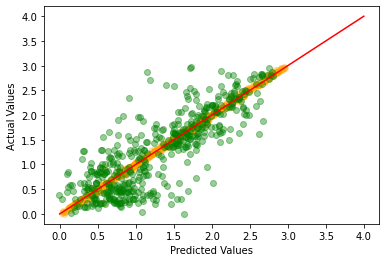

In [192]:
plt.scatter(y_train_pred, np.array(As_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(As_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 4.0], [0, 4.0], color='red', linestyle='-')

plt.show()

Cd

Optimization

In [193]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="lgbm_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveLGBM(trial, Cd_X_train, Cd_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-17 22:27:21,589] A new study created in memory with name: lgbm_parameter_opt
[I 2023-08-17 22:27:23,916] Trial 0 finished with value: 0.647347673831687 and parameters: {'n_estimators': 896, 'max_depth': 26, 'num_leaves': 20, 'min_child_samples': 1, 'num_iterations': 636}. Best is trial 0 with value: 0.647347673831687.
[I 2023-08-17 22:27:26,682] Trial 1 finished with value: 0.6509718767870722 and parameters: {'n_estimators': 638, 'max_depth': 12, 'num_leaves': 18, 'min_child_samples': 7, 'num_iterations': 997}. Best is trial 1 with value: 0.6509718767870722.
[I 2023-08-17 22:27:28,638] Trial 2 finished with value: 0.6422511425081117 and parameters: {'n_estimators': 659, 'max_depth': 17, 'num_leaves': 11, 'min_child_samples': 3, 'num_iterations': 927}. Best is trial 1 with value: 0.6509718767870722.
[I 2023-08-17 22:27:30,949] Trial 3 finished with value: 0.6527053016728892 and parameters: {'n_estimators': 808, 'max_depth': 27, 'num_leaves': 19, 'min_child_samples': 10, 'num_

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-08-17 22:29:33,021] Trial 53 finished with value: 0.655492037103816 and parameters: {'n_estimators': 753, 'max_depth': 30, 'num_leaves': 31, 'min_child_samples': 3, 'num_iterations': 828}. Best is trial 32 with value: 0.6615934552120268.
[I 2023-08-17 22:29:36,347] Trial 54 finished with value: 0.6593657403021688 and parameters: {'n_estimators': 761, 'max_depth': 30, 'num_leaves': 32, 'min_child_samples': 3, 'num_iterations': 762}. Best is trial 32 with value: 0.6615934552120268.
[I 2023-08-17 22:29:40,163] Trial 55 finished with value: 0.659359684169155 and parameters: {'n_estimators': 698, 'max_depth': 28, 'num_leaves': 32, 'min_child_samples': 3, 'num_iterations': 745}. Best is trial 32 with value: 0.6615934552120268.
[I 2023-08-17 22:29:43,591] Trial 56 finished with value: 0.6516533287607029 and parameters: {'n_estimators': 765, 'max_depth': 28, 'num_leaves': 32, 'min_child_samples': 4, 'num_iterations': 732}. Best is trial 32 with value: 0.6615934552120268.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-08-17 22:29:46,719] Trial 57 finished with value: 0.6555630181498046 and parameters: {'n_estimators': 641, 'max_depth': 28, 'num_leaves': 31, 'min_child_samples': 3, 'num_iterations': 726}. Best is trial 32 with value: 0.6615934552120268.
[I 2023-08-17 22:29:49,468] Trial 58 finished with value: 0.6524628493938244 and parameters: {'n_estimators': 692, 'max_depth': 27, 'num_leaves': 32, 'min_child_samples': 5, 'num_iterations': 642}. Best is trial 32 with value: 0.6615934552120268.
[I 2023-08-17 22:29:52,751] Trial 59 finished with value: 0.6444950004334817 and parameters: {'n_estimators': 720, 'max_depth': 30, 'num_leaves': 29, 'min_child_samples': 3, 'num_iterations': 766}. Best is trial 32 with value: 0.6615934552120268.
[I 2023-08-17 22:29:56,495] Trial 60 finished with value: 0.6599426992881108 and parameters: {'n_estimators': 735, 'max_depth': 25, 'num_leaves': 30, 'min_child_samples': 4, 'num_iterations': 665}. Best is trial 32 with value: 0.6615934552120268.
[I 2023-08-1

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-08-17 22:30:38,228] Trial 76 finished with value: 0.6520761872333132 and parameters: {'n_estimators': 623, 'max_depth': 23, 'num_leaves': 31, 'min_child_samples': 6, 'num_iterations': 616}. Best is trial 67 with value: 0.6625524796588808.
[I 2023-08-17 22:30:40,186] Trial 77 finished with value: 0.6519452349742796 and parameters: {'n_estimators': 710, 'max_depth': 26, 'num_leaves': 28, 'min_child_samples': 4, 'num_iterations': 505}. Best is trial 67 with value: 0.6625524796588808.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-08-17 22:30:42,609] Trial 78 finished with value: 0.6519296513736056 and parameters: {'n_estimators': 654, 'max_depth': 21, 'num_leaves': 31, 'min_child_samples': 4, 'num_iterations': 565}. Best is trial 67 with value: 0.6625524796588808.
[I 2023-08-17 22:30:43,580] Trial 79 finished with value: 0.6498864653734374 and parameters: {'n_estimators': 686, 'max_depth': 26, 'num_leaves': 10, 'min_child_samples': 5, 'num_iterations': 601}. Best is trial 67 with value: 0.6625524796588808.
[I 2023-08-17 22:30:46,099] Trial 80 finished with value: 0.6503854868670078 and parameters: {'n_estimators': 744, 'max_depth': 24, 'num_leaves': 27, 'min_child_samples': 4, 'num_iterations': 668}. Best is trial 67 with value: 0.6625524796588808.
[I 2023-08-17 22:30:48,902] Trial 81 finished with value: 0.659943446609972 and parameters: {'n_estimators': 731, 'max_depth': 22, 'num_leaves': 30, 'min_child_samples': 4, 'num_iterations': 663}. Best is trial 67 with value: 0.6625524796588808.
[I 2023-08-17

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-08-17 22:31:07,849] Trial 89 finished with value: 0.6508760003232951 and parameters: {'n_estimators': 590, 'max_depth': 23, 'num_leaves': 31, 'min_child_samples': 5, 'num_iterations': 571}. Best is trial 84 with value: 0.6649129906787159.
[I 2023-08-17 22:31:10,896] Trial 90 finished with value: 0.662469978609374 and parameters: {'n_estimators': 564, 'max_depth': 25, 'num_leaves': 29, 'min_child_samples': 4, 'num_iterations': 628}. Best is trial 84 with value: 0.6649129906787159.
[I 2023-08-17 22:31:13,665] Trial 91 finished with value: 0.6624687201699613 and parameters: {'n_estimators': 538, 'max_depth': 25, 'num_leaves': 29, 'min_child_samples': 4, 'num_iterations': 626}. Best is trial 84 with value: 0.6649129906787159.
[I 2023-08-17 22:31:16,160] Trial 92 finished with value: 0.662469978609374 and parameters: {'n_estimators': 538, 'max_depth': 25, 'num_leaves': 29, 'min_child_samples': 4, 'num_iterations': 628}. Best is trial 84 with value: 0.6649129906787159.
[I 2023-08-17 

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-08-17 22:31:34,046] Trial 99 finished with value: 0.6601813759246732 and parameters: {'n_estimators': 527, 'max_depth': 14, 'num_leaves': 31, 'min_child_samples': 3, 'num_iterations': 606}. Best is trial 84 with value: 0.6649129906787159.


Best r2:  0.6649129906787159
Best trial: {'n_estimators': 669, 'max_depth': 17, 'num_leaves': 29, 'min_child_samples': 4, 'num_iterations': 582}


In [194]:
optuna.visualization.plot_parallel_coordinate(study)

In [210]:
print("Best trial:", study.best_trial.params)
study.best_trial.params["n_estimators"]

Best trial: {'n_estimators': 951, 'max_depth': 17, 'num_leaves': 11, 'min_child_samples': 10, 'num_iterations': 716}


951

In [211]:
lgbm_params = {
    "random_state": 42,
    "learning_rate": 0.1,
    "n_estimators": study.best_trial.params["n_estimators"],
    "max_depth": study.best_trial.params["max_depth"],
    "num_leaves": study.best_trial.params["num_leaves"],
    "min_child_samples": study.best_trial.params["min_child_samples"],
    "num_iterations": study.best_trial.params["num_iterations"]
}

lgbm = LGBMRegressor(**lgbm_params)
lgbm.fit(Cd_X_train, Cd_y_train)

LGBMRegressor(max_depth=17, min_child_samples=10, n_estimators=951,
              num_iterations=716, num_leaves=11, random_state=42)

In [212]:
y_train_pred = lgbm.predict(Cd_X_train)
y_test_pred = lgbm.predict(Cd_X_test)

In [213]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Cd_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Cd_y_test, y_test_pred)))

Train RMSE:  0.028810187724987033
Test RMSE:  0.13156612310618346


In [214]:
print("Train R2: ", r2_score(Cd_y_train, y_train_pred))
print("Test R2: ", r2_score(Cd_y_test, y_test_pred))

Train R2:  0.9838624661741021
Test R2:  0.6852526076302126


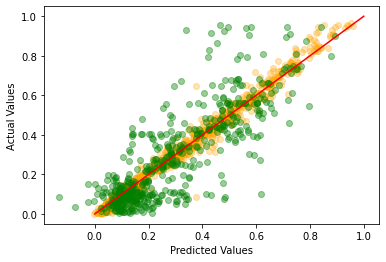

In [215]:
plt.scatter(y_train_pred, np.array(Cd_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Cd_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 1.0], [0, 1.0], color='red', linestyle='-')

plt.show()

Ni

In [201]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="lgbm_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveLGBM(trial, Ni_X_train, Ni_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-17 22:31:35,248] A new study created in memory with name: lgbm_parameter_opt
[I 2023-08-17 22:31:36,078] Trial 0 finished with value: 0.7199971915851875 and parameters: {'n_estimators': 551, 'max_depth': 4, 'num_leaves': 6, 'min_child_samples': 6, 'num_iterations': 607}. Best is trial 0 with value: 0.7199971915851875.
[I 2023-08-17 22:31:38,018] Trial 1 finished with value: 0.7430175727964228 and parameters: {'n_estimators': 774, 'max_depth': 25, 'num_leaves': 17, 'min_child_samples': 6, 'num_iterations': 826}. Best is trial 1 with value: 0.7430175727964228.
[I 2023-08-17 22:31:38,486] Trial 2 finished with value: 0.6952480645394388 and parameters: {'n_estimators': 652, 'max_depth': 30, 'num_leaves': 3, 'min_child_samples': 9, 'num_iterations': 652}. Best is trial 1 with value: 0.7430175727964228.
[I 2023-08-17 22:31:39,557] Trial 3 finished with value: 0.7364130942849619 and parameters: {'n_estimators': 640, 'max_depth': 11, 'num_leaves': 8, 'min_child_samples': 2, 'num_ite

Best r2:  0.7483105558826864
Best trial: {'n_estimators': 951, 'max_depth': 17, 'num_leaves': 11, 'min_child_samples': 10, 'num_iterations': 716}


In [202]:
optuna.visualization.plot_parallel_coordinate(study)

In [203]:
print("Best trial:", study.best_trial.params)
study.best_trial.params["n_estimators"]

Best trial: {'n_estimators': 951, 'max_depth': 17, 'num_leaves': 11, 'min_child_samples': 10, 'num_iterations': 716}


951

In [204]:
lgbm_params = {
    "random_state": 42,
    "learning_rate": 0.1,
    "n_estimators": study.best_trial.params["n_estimators"],
    "max_depth": study.best_trial.params["max_depth"],
    "num_leaves": study.best_trial.params["num_leaves"],
    "min_child_samples": study.best_trial.params["min_child_samples"],
    "num_iterations": study.best_trial.params["num_iterations"]
}

lgbm = LGBMRegressor(**lgbm_params)
lgbm.fit(Ni_X_train, Ni_y_train)

LGBMRegressor(max_depth=17, min_child_samples=10, n_estimators=951,
              num_iterations=716, num_leaves=11, random_state=42)

In [205]:
y_train_pred = lgbm.predict(Ni_X_train)
y_test_pred = lgbm.predict(Ni_X_test)

In [206]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Ni_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Ni_y_test, y_test_pred)))

Train RMSE:  0.11209746703429181
Test RMSE:  0.5550780639891302


In [207]:
print("Train R2: ", r2_score(Ni_y_train, y_train_pred))
print("Test R2: ", r2_score(Ni_y_test, y_test_pred))

Train R2:  0.9915621940017411
Test R2:  0.7841244786523676


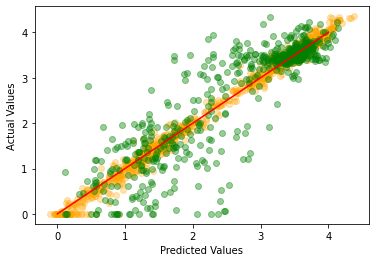

In [208]:
plt.scatter(y_train_pred, np.array(Ni_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Ni_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 4.0], [0, 4.0], color='red', linestyle='-')

plt.show()